# YandexgGPT results in Centipede game

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('solo_results_llm_first_move.csv')

In [3]:
df.shape

(2162, 6)

In [4]:
df.sample(5)

,game,round,player,emotional_state,action,explanation
2047,2b989b1d-af2a-4533-bc43-56f4e90aa7c2,7,Пользователь_1,нейтральный,pass,\n\nв текущем раунде выгоднее передать обе сто...
1658,4c2c455e-7b1c-4e26-9c24-9ae090e9bdbd,4,Пользователь_2,неважно,pass,без комментариев
1092,687dce24-f468-4d3d-b412-d47bad1d4538,6,Пользователь_2,неважно,pass,без комментариев
1961,fef98944-23c5-4b10-a591-e57366fb7fa6,1,Пользователь_1,злой,take,"\n\nпоскольку я злой, то могу попытаться сразу..."
1809,f982a215-2fcf-45b9-8ec4-bee2c2f6796f,4,Пользователь_2,неважно,pass,без комментариев


In [5]:
df['emotional_state'].unique()

array(['радостный', 'грустный', 'неважно', 'гневный', 'испуганный',
       'удивленный', 'злой', 'нейтральный'], dtype=object)

#### Можем выкинуть эти строки, так как они не влияют на дальнейший анализ (по сути избавились от 2-го игрока)

In [6]:
df = df[df['emotional_state'] != 'неважно']

#### Число игр для каждого эмоционального состояния (проверить баланс классов)

In [7]:
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  661


,emotional_state,Number_of_Games
0,гневный,91
1,грустный,100
2,злой,100
3,испуганный,100
4,нейтральный,90
5,радостный,85
6,удивленный,95


#### Максимальное число раундов для каждого эмоционального состояния

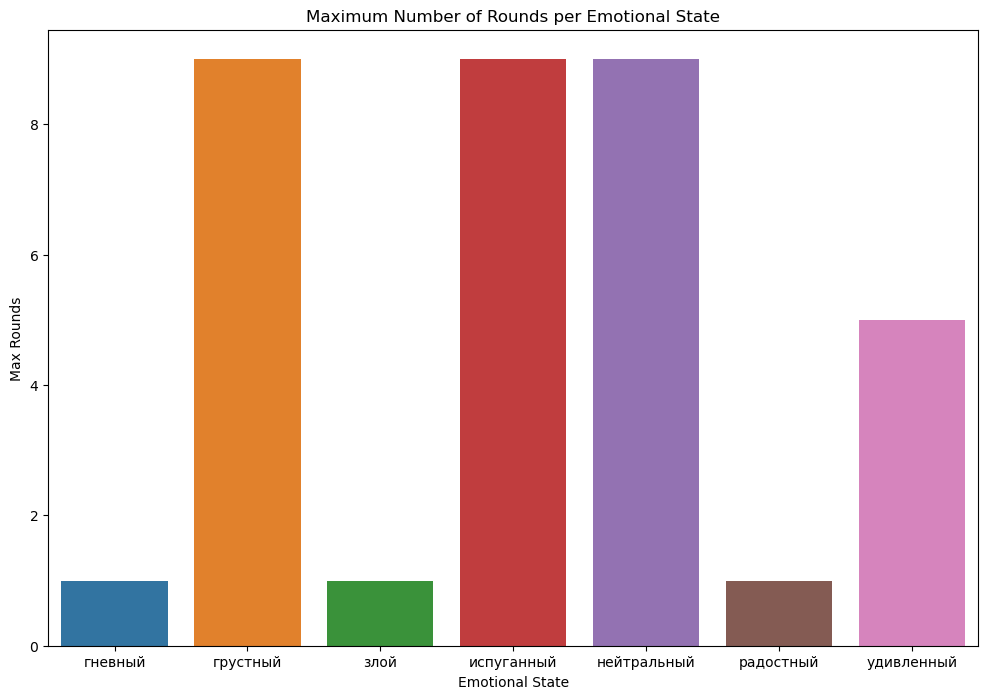

In [8]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

#### Среднее число раундов для каждого эмоционального состояния

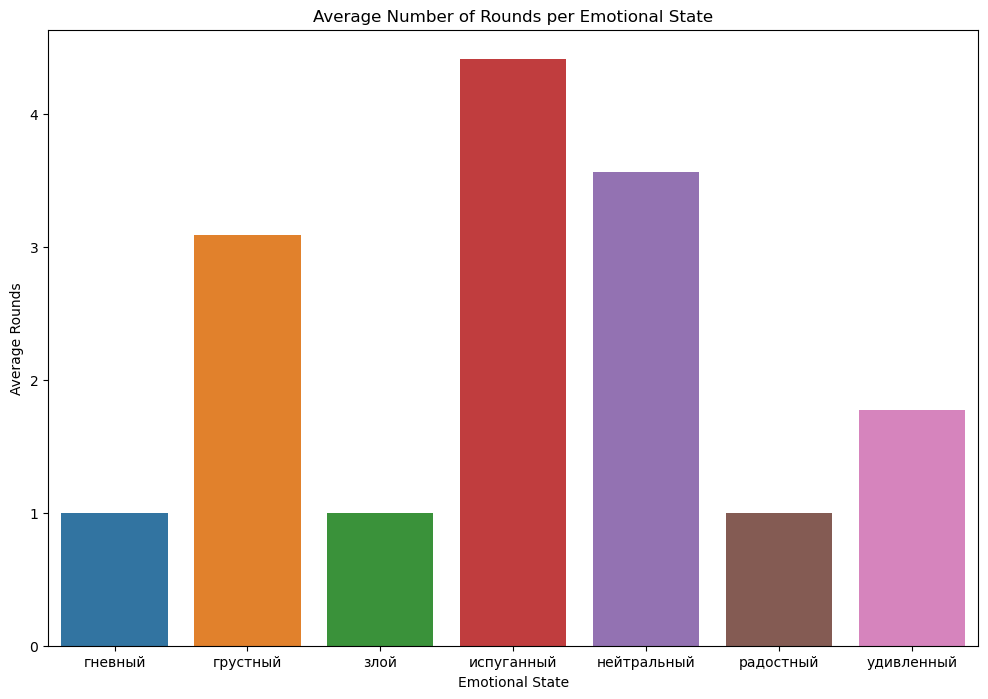

In [9]:
avg_rounds_per_emotional_state = df.groupby('emotional_state')['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [10]:
avg_rounds_per_emotional_state

,emotional_state,avg_round
0,гневный,1.000000
1,грустный,3.091873
2,злой,1.000000
3,испуганный,4.415313
4,нейтральный,3.562278
5,радостный,1.000000
6,удивленный,1.771429


#### Медианное число раундов для каждого эмоционального состояния

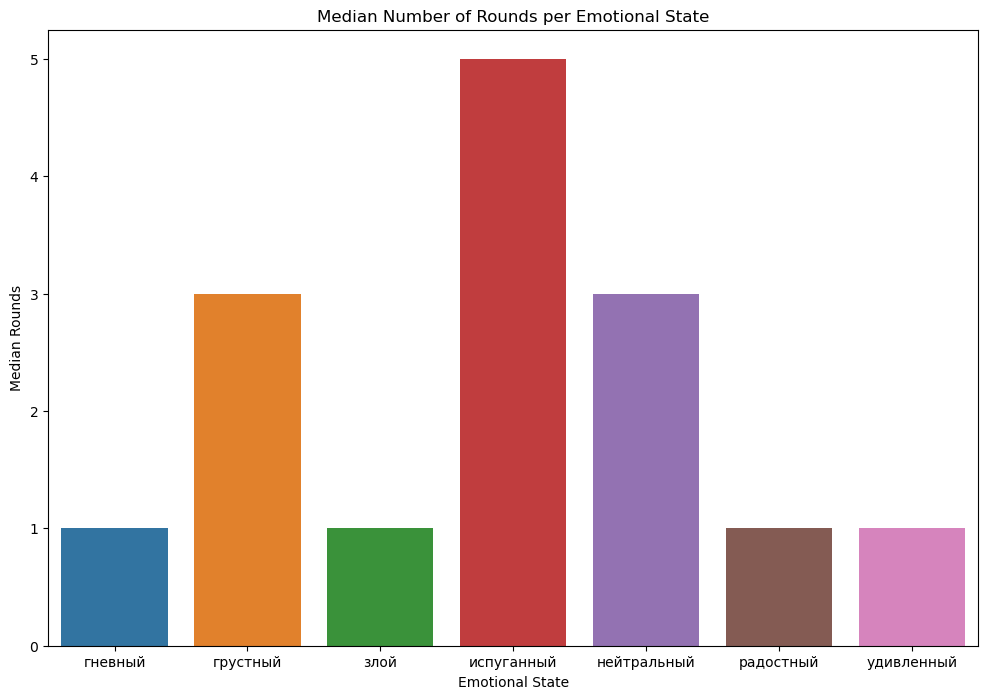

In [11]:
median_rounds_per_emotional_state = df.groupby('emotional_state')['round'].median().reset_index()
median_rounds_per_emotional_state.columns = ['emotional_state', 'median_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=median_rounds_per_emotional_state, x='emotional_state', y='median_round')
plt.title('Median Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Median Rounds')
plt.show()

# Ananlysis

In [12]:
df_grouped = df.groupby('emotional_state')['explanation'].apply(lambda x: ' '.join(x)).reset_index()

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian') + ['это'])
morph = MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()
    # Убираем пунктуацию и числа
    text = re.sub(r'\W+', ' ', text)
    
    words = text.split()
    words = [morph.normal_forms(word)[0] for word in words if word not in stop_words]
    return ' '.join(words)

df_grouped['cleaned_explanation'] = df_grouped['explanation'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])
cosine_similarities = cosine_similarity(X, X)

similarity_df = pd.DataFrame(cosine_similarities, index=df_grouped['emotional_state'], columns=df_grouped['emotional_state'])

def get_similar_emotional_states(similarity_df, threshold=0.5):
    similar_states = []
    for i in range(len(similarity_df)):
        for j in range(i+1, len(similarity_df)):
            if similarity_df.iloc[i, j] > threshold:
                similar_states.append((similarity_df.index[i], similarity_df.index[j], similarity_df.iloc[i, j]))
    return similar_states

similar_states = get_similar_emotional_states(similarity_df, threshold=0.8)

In [15]:
similar_states

[('грустный', 'нейтральный', 0.9053331581904615),
 ('грустный', 'удивленный', 0.8283420621207741),
 ('нейтральный', 'радостный', 0.8217218077311015),
 ('нейтральный', 'удивленный', 0.8718247384337245),
 ('радостный', 'удивленный', 0.8036095308324874)]

#### Нужно переписать!

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])

feature_names = vectorizer.get_feature_names_out()

tfidf_sums = X.sum(axis=0).A1

tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_sum': tfidf_sums})

tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

top_n = 15
top_terms = tfidf_df.head(top_n)

In [17]:
top_terms

,term,tfidf_sum
312,монета,3.180597
825,стопка,2.383819
711,раунд,1.821773
210,игра,1.589996
41,больший,1.235116
70,взять,1.217818
431,оппонент,1.088398
480,первый,0.975791
538,получить,0.938237
213,игрок,0.845248
